In [10]:
import pandas as pd
import string
import nltk
import numpy as np
import tensorflow as tf
import pickle 

from scipy.sparse import dok_matrix
from scipy.spatial.distance import euclidean
from tensorflow.keras import layers, models, losses

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
df = pd.read_csv("data/emails.csv")
X = df.Text
y = df.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Preprocessing
- Get the vocabulary of the training set
- Create functions to convert integers to respective words and vice-versa

In [3]:
def get_words(document: list[str]):
    """
    Given a document, parses it's tokens, removing stopwords and punctuation;
    """
    stopwords = set(map(str.lower, nltk.corpus.stopwords.words("english")))
    punctuation = set(string.punctuation)
    for word in nltk.tokenize.word_tokenize(document):
        word = word.lower()
        if (word not in stopwords) and \
        (word not in punctuation):
            yield word

In [4]:
def process_documents(docs):
    all_words = {}
    sentences = []
    index = 0

    for doc in docs:
        for sentence in nltk.tokenize.sent_tokenize(doc):
            current_sentence = []
            for word in get_words(sentence):
                if word not in all_words:
                    all_words|= {word:index}
                    index+=1
                current_sentence.append(word)
            sentences.append(current_sentence)
    return all_words, sentences

In [53]:
all_words, emails = process_documents(X_train)

In [54]:
rev_words = {item[1]:item[0] for item in all_words.items()}

In [55]:
M = len(all_words)

In [56]:
M

33660

In [57]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

## GloVe Embedding
- We will try to detect for ham or spam using GloVe representation

First we need to create the word representations

In [28]:
def count_word_coocurrence(docs, vocab, wsize=10):
    term_term_dict = {}
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    M = len(vocab)
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        term_term_sparse[i, j] = value
        
    return term_term_sparse

In [31]:
word_cooc_matrix = count_word_coocurrence(emails, all_words, wsize=5)

In [35]:
def get_training_sets(cooc: dok_matrix):
    X = np.array(
        list(
            cooc.keys()
        )
    )
    y = np.array(
        list(
            cooc.values()
        )
    )
    
    return X, y

In [36]:
X, y = get_training_sets(word_cooc_matrix)

In [37]:
X.shape

(906640, 2)

In [38]:
#small embedding dim since the dataset is small
EMB_SIZE=50

In [42]:
target = layers.Input(shape=1, name="context_input")
context = layers.Input(shape=1, name="target_input")

embed_layer = layers.Embedding(
    input_dim=word_cooc_matrix.shape[0], 
    output_dim=EMB_SIZE, 
    name="embed"
)

embed_target = embed_layer(target)
embed_context = embed_layer(context)

dot = layers.Dot(axes=2)( [ embed_target, embed_context ] )
flat = layers.Flatten()(dot)

model = models.Model(inputs=[ target, context ], outputs=flat)

In [16]:
@tf.function
def loss(y_test, preds):
    x_max = 100
    α = 0.75
    
    G = tf.where(y_test < x_max, (y_test/x_max)**α, 1)
    temp = tf.math.log(y_test)
    
    return tf.reduce_sum(
      G *(preds - temp)**2  
    )

In [44]:
model.compile(optimizer="adam", loss=loss)

In [68]:
model.fit([ X[:,0], X[:,1] ], y, epochs=1, batch_size=128)

7084/7084 [==============================] - 45s 6ms/step - loss: 1.1496


In [69]:
embed_vectors = model.get_weights()[0]

In [79]:
np.save("./data/glove_vectors.npy", embed_vectors)

## Continuous Bag of Words Embedding

In [95]:
def get_dataset(docs, wsize=2):
    dataset = {}
    
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            context_set = tuple()
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                context_set = context_set + (prev_word, future_word)
            context_set = tuple(sorted(context_set))
            
            dataset[context_set] = dataset.get(context_set, set()) | {current_word}
    return dataset

In [96]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y).reshape(-1,1)

In [97]:
wsize=4

In [99]:
ds = get_dataset(emails, wsize)

In [100]:
contexts, targets = unwind(ds)

In [101]:
EMB_SIZE=50

In [103]:
model = models.Sequential([
    layers.Embedding(
        input_dim=M, 
        output_dim=EMB_SIZE, 
        input_length=wsize*2,
        name="embeding_layer"),
    layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=EMB_SIZE, name="mean_layer"),
    layers.Dense(units=M, activation="softmax", name="activation_layer")
])
    

In [107]:
model.compile("adam", loss="sparse_categorical_crossentropy")

In [131]:
model.fit(x=contexts, y=targets, batch_size=64, epochs=5)

Epoch 1/5
3188/3188 [==============================] - 35s 11ms/step - loss: 5.4432
Epoch 2/5
3188/3188 [==============================] - 34s 11ms/step - loss: 5.2723
Epoch 3/5
3188/3188 [==============================] - 34s 11ms/step - loss: 5.1111
Epoch 4/5
3188/3188 [==============================] - 34s 11ms/step - loss: 4.9599
Epoch 5/5
3188/3188 [==============================] - 34s 11ms/step - loss: 4.8178


In [132]:
embed_vectors = model.get_weights()[0]

In [151]:
np.save("./data/cbow_vectors.npy", embed_vectors)

## Document Representation
- Each document will be reduced to a vector, which will be the mean of the words that appear in the document

In [24]:
EMB_SIZE=50

In [21]:
def get_existing_words(document, vocab):
    """
    Given a document, parses it's tokens, removing stopwords and punctuation;
    It also filters words that are not in the vocabulary
    """
    stopwords = set(map(str.lower, nltk.corpus.stopwords.words("english")))
    punctuation = set(string.punctuation)
    for word in nltk.tokenize.word_tokenize(document):
        word = word.lower()
        if (word not in stopwords) and \
        (word not in punctuation) and \
        (word in vocab):
            yield word

In [22]:
def get_doc_representation(corpus, emb_size, emb_vectors, vocab):
    vectors = []
    for doc in corpus:
        vec = np.zeros(emb_size)
        wcount=0
        for sentence in nltk.tokenize.sent_tokenize(doc):
            for word in get_existing_words(sentence, vocab):
                vec += emb_vectors[ word2int(word) ]
                wcount+=1
        
        vectors.append(vec/wcount)
    return vectors

In [65]:
train_vectors = np.array(
    get_doc_representation(X_train, EMB_SIZE, embed_vectors, all_words)
)

In [66]:
test_vectors = np.array(
    get_doc_representation(X_test, EMB_SIZE, embed_vectors, all_words)
)

## Training/Testing the model

- we will use SVM as they are very robust

In [ ]:
embed_vectors=np.load("./data/glove_vectors.npy")

In [67]:
model = SVC().fit(train_vectors, y_train)

In [68]:
preds = model.predict(test_vectors)

- GloVe Embedding

In [62]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       885
           1       0.93      0.90      0.92       261

    accuracy                           0.96      1146
   macro avg       0.95      0.94      0.95      1146
weighted avg       0.96      0.96      0.96      1146



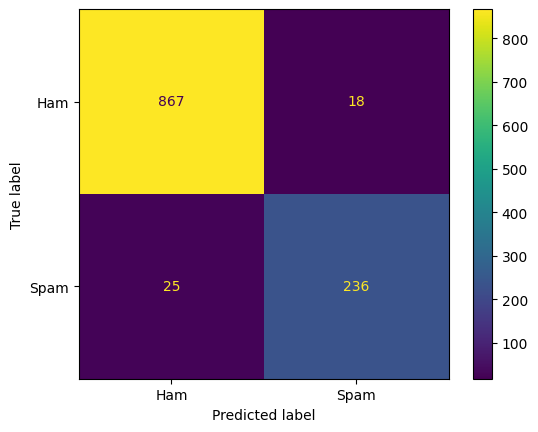

In [63]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,preds), display_labels=["Ham", "Spam"]
).plot()

- CBOW Embedding

In [64]:
embed_vectors = np.load("./data/cbow_vectors.npy")

In [69]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       885
           1       0.95      0.93      0.94       261

    accuracy                           0.97      1146
   macro avg       0.97      0.96      0.96      1146
weighted avg       0.97      0.97      0.97      1146



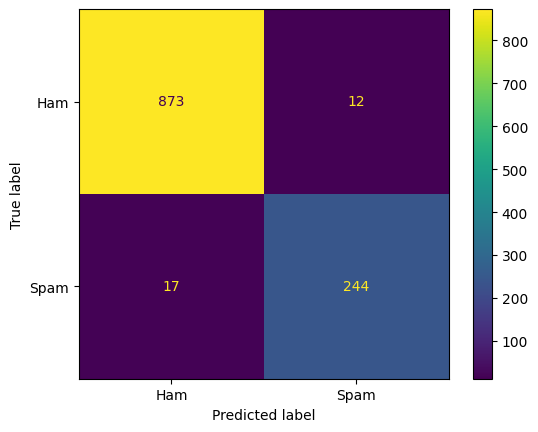

In [70]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,preds), display_labels=["Ham", "Spam"]
).plot()